In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pydub


In [ ]:
# Import necessary libraries 
from pydub import AudioSegment 


# Input audio file to be sliced 
audio = AudioSegment.from_wav("1.wav") 
n = len(audio) 

# Variable to count the number of sliced chunks 
counter = 1
interval = 6 * 1000

# Length of audio to overlap. 

overlap = 2 * 1000

# Initialize start and end seconds to 0 
start = 0
end = 0

# Flag to keep track of end of file. 
# When audio reaches its end, flag is set to 1 and we break 
flag = 0


for i in range(0, 2 * n, interval): 
	
	# During first iteration, 
	# start is 0, end is the interval 
	if i == 0: 
		start = 0
		end = interval 

	# All other iterations, 
	# start is the previous end - overlap 
	# end becomes end + interval 
	else: 
		start = end - overlap 
		end = start + interval 

	if end >= n: 
		end = n 
		flag = 1

	# Storing audio file from the defined start to end 
	chunk = audio[start:end] 

	# Filename / Path to store the sliced audio 
	filename = 'chunk'+str(counter)+'.wav'

	# Store the sliced audio file to the defined path 
	chunk.export(filename, format ="wav") 
	# Print information about the current chunk 
	print("Processing chunk "+str(counter)+". Start = "
						+str(start)+" end = "+str(end)) 

	# Increment counter for the next chunk 
	counter = counter + 1
	
	# Slicing of the audio file is done. 
	# Skip the below steps if there is some other usage 
	# for the sliced audio files. 


	if flag == 1: 
		break


FileNotFoundError: ignored

In [ ]:
import os
from pydub import AudioSegment
src_path='./gdrive/My Drive/Colab Notebooks/project/genres'
genres_dict={'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5,'metal':6,'pop':7,'reggae':8,'rock':9}
counter1=1
for x,_ in genres_dict.items():
    folder=src_path + '/' + x
    for root,subdirs,files in os.walk(folder):
        for file in files:
            filename=folder + '/' + file
            audio = AudioSegment.from_wav(filename) 
            n = len(audio)
            counter = 1
            interval = 8 * 1000
            overlap = 2 * 1000
            start = 0
            end=0
            flag = 0
            for i in range(0, 2 * n, interval):
                
                if(i == 0):
                    start = 0
                    end=interval
		        
                    
                else:
                    start = end - overlap
                    end=start+interval
		            
               
                if end >= n:
                    end = n 
                    flag = 1
                chunk = audio[start:end] 
                chunkfile ='chunk'+str(counter1)+'.wav'
                des=folder + '/' + chunkfile
                chunk.export(des, format ="wav")
                print("Processing chunk "+str(counter)+". Start = "
						+str(start)+" end = "+str(end))
                counter=counter+1
                counter1=counter1+1
                if(flag == 1):
                    break

            

            

Processing chunk 1. Start = 0 end = 8000
Processing chunk 2. Start = 6000 end = 14000
Processing chunk 3. Start = 12000 end = 20000
Processing chunk 4. Start = 18000 end = 26000
Processing chunk 5. Start = 24000 end = 30013
Processing chunk 1. Start = 0 end = 8000
Processing chunk 2. Start = 6000 end = 14000
Processing chunk 3. Start = 12000 end = 20000
Processing chunk 4. Start = 18000 end = 26000
Processing chunk 5. Start = 24000 end = 30013
Processing chunk 1. Start = 0 end = 8000
Processing chunk 2. Start = 6000 end = 14000
Processing chunk 3. Start = 12000 end = 20000
Processing chunk 4. Start = 18000 end = 26000
Processing chunk 5. Start = 24000 end = 30013
Processing chunk 1. Start = 0 end = 8000
Processing chunk 2. Start = 6000 end = 14000
Processing chunk 3. Start = 12000 end = 20000
Processing chunk 4. Start = 18000 end = 26000
Processing chunk 5. Start = 24000 end = 30013
Processing chunk 1. Start = 0 end = 8000
Processing chunk 2. Start = 6000 end = 14000
Processing chunk 3

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from scipy import stats
import warnings
import seaborn as sns
import multiprocessing as mp
%matplotlib inline

In [ ]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)
    #columns.extend('genres')

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()

In [ ]:
def compute_features(filename,tid):

    features = pd.Series(index=columns(), dtype=np.float32,name=tid)

    # Catch warnings as exceptions (audioread leaks file descriptors).
    warnings.filterwarnings('error', module='librosa')

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    try:
        
        x, sr = librosa.load(filename, sr=None, mono=True)  # kaiser_fast

        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
        feature_stats('zcr', f)

        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cqt', f)
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cens', f)
        f = librosa.feature.tonnetz(chroma=f)
        feature_stats('tonnetz', f)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
        del x

        f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
        feature_stats('chroma_stft', f)

        f = librosa.feature.rmse(S=stft)
        feature_stats('rmse', f)

        f = librosa.feature.spectral_centroid(S=stft)
        feature_stats('spectral_centroid', f)
        f = librosa.feature.spectral_bandwidth(S=stft)
        feature_stats('spectral_bandwidth', f)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
        feature_stats('spectral_contrast', f)
        f = librosa.feature.spectral_rolloff(S=stft)
        feature_stats('spectral_rolloff', f)

        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
        feature_stats('mfcc', f)

    except Exception as e:
        print(' {}'.format(repr(e)))

    return features

In [ ]:
def collect_result(it):
    global features
    features=features.append(it)

In [ ]:
arr=[]
genres=[]
track_id=0
features=pd.DataFrame(index=arr,columns=columns(),dtype=np.float32)
src_path='./gdrive/My Drive/Colab Notebooks/project/genres'
genres_dict={'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5,'metal':6,'pop':7,'reggae':8,'rock':9}
for x,_ in genres_dict.items():
    folder=src_path + '/' + x
    for root,subdirs,files in os.walk(folder):
        for file in files:
            genres.append(x)
            filename=folder + '/' + file
            it=compute_features(filename,track_id)
            features=features.append(it)
            track_id += 1
features['genres']=genres

In [ ]:
 def save(features, ndigits):

    # Should be done already, just to be sure.
    features.sort_index(axis=0, inplace=True)
    features.sort_index(axis=1, inplace=True)

    features.to_csv('./gdrive/My Drive/Colab Notebooks/project/features1.csv', float_format='%.{}e'.format(ndigits))

In [ ]:
save(features, 10)

In [ ]:
data=pd.read_csv('./gdrive/My Drive/Colab Notebooks/project/features1.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,2

In [ ]:
data=data.iloc[2:,1:]

In [ ]:
data=data.reindex(np.random.permutation(data.index))

In [ ]:
y=data['genres']
del data['genres']

In [ ]:
data=data.astype(float)

In [ ]:
data.columns

Index(['chroma_cens', 'chroma_cens.1', 'chroma_cens.2', 'chroma_cens.3',
       'chroma_cens.4', 'chroma_cens.5', 'chroma_cens.6', 'chroma_cens.7',
       'chroma_cens.8', 'chroma_cens.9',
       ...
       'tonnetz.39', 'tonnetz.40', 'tonnetz.41', 'zcr', 'zcr.1', 'zcr.2',
       'zcr.3', 'zcr.4', 'zcr.5', 'zcr.6'],
      dtype='object', length=518)

In [ ]:
!pip install sklearn

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:


from sklearn.preprocessing import StandardScaler

X_train1, X_test1, y_train1, y_test1 = train_test_split(data, y, test_size=0.25, random_state=1)

scaler = StandardScaler().fit(X_train1)
X_train1 = scaler.transform(X_train1)

X_test1 = scaler.transform(X_test1)


# create the linear model classifier
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
# fit (train) the classifier
clf.fit(X_train1, y_train1)


from sklearn import metrics
y_train_pred1 = clf.predict(X_train1)
print(metrics.accuracy_score(y_train1, y_train_pred1))

y_pred1 = clf.predict(X_test1)
print(metrics.accuracy_score(y_test1, y_pred1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.894
0.8173333333333334


In [ ]:
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train1, y_train1, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test1)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test1, y_test1)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 93.27%


In [ ]:
def learn_result(X_train,y_train,X_test,y_test,Classifier):
    if Classifier == "SGD":
        from sklearn.linear_model import SGDClassifier
        clf = SGDClassifier()
    if Classifier == "KNN":
        from sklearn.neighbors import KNeighborsClassifier
        clf = KNeighborsClassifier()
    if Classifier == "SVM":
        from sklearn import svm
        clf = svm.LinearSVC()
    if Classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=10)
    if Classifier == "GNB":
        from sklearn.naive_bayes import GaussianNB
        clf = GaussianNB()
   

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_acc = metrics.accuracy_score(y_train,clf.predict(X_train))
    test_acc = metrics.accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm)
    return train_acc,test_acc,y_pred

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genre_list))
    plt.xticks(tick_marks, genre_list, rotation=45)
    plt.yticks(tick_marks, genre_list)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

genre_list = ['classical','rock','country','metal','jazz','blues','hiphop','reggae','disco','pop']

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[89.47, 96.09, 99.69, 99.76, 62.27]
[81.73, 90.6, 81.8, 82.13, 61.67]


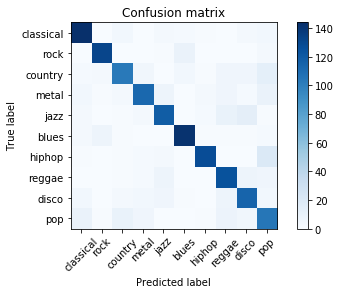

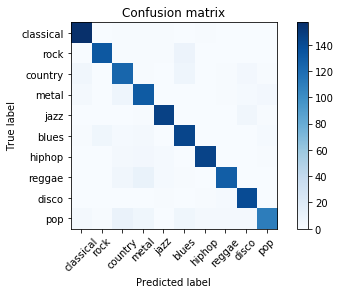

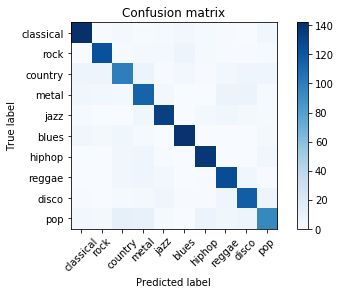

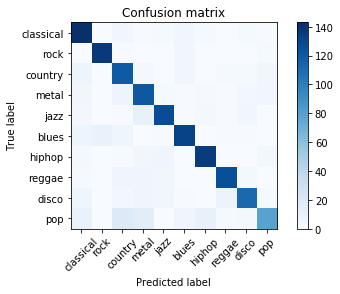

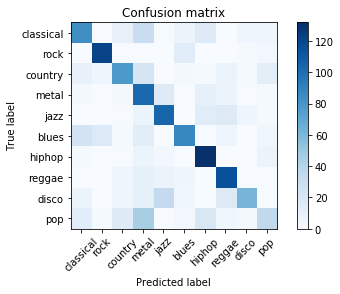

In [ ]:
from matplotlib import pylab
from sklearn.metrics import confusion_matrix
Classifiers = ["SGD","KNN","SVM","RF","GNB"]
train_accs = []
test_accs = []
X_train1, X_test1, y_train1, y_test1 = train_test_split(data, y, test_size=0.25, random_state=1)
scaler = StandardScaler().fit(X_train1)
for Classifier in Classifiers:
	train_acc,test_acc,_ = learn_result(scaler.transform(X_train1),y_train1,scaler.transform(X_test1),y_test1,Classifier)
	train_acc_perc = round(train_acc*100,2)
	test_acc_perc = round(test_acc*100,2)
	train_accs.append(train_acc_perc)
	test_accs.append(test_acc_perc)
    
print(train_accs)
print(test_accs)

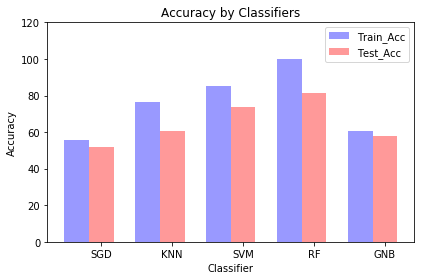

In [ ]:
%matplotlib inline


import numpy as np  
import matplotlib.pyplot as plt  

n_groups = len(Classifiers) 

fig, ax = plt.subplots()  
index = np.arange(n_groups)  
bar_width = 0.35  
   
opacity = 0.4  
rects1 = plt.bar(index, train_accs, bar_width,alpha=opacity, color='b',label= 'Train_Acc')  
rects2 = plt.bar(index + bar_width, test_accs, bar_width,alpha=opacity,color='r',label='Test_Acc')  
   
plt.xlabel('Classifier')  
plt.ylabel('Accuracy')  
plt.title('Accuracy by Classifiers')  
plt.xticks(index + bar_width, ("SGD","KNN","SVM","RF","GNB"))  
plt.ylim(0,120)  
plt.legend()  
   
plt.tight_layout()  
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

data_rescaled = StandardScaler().fit_transform(data)
from sklearn.decomposition import PCA

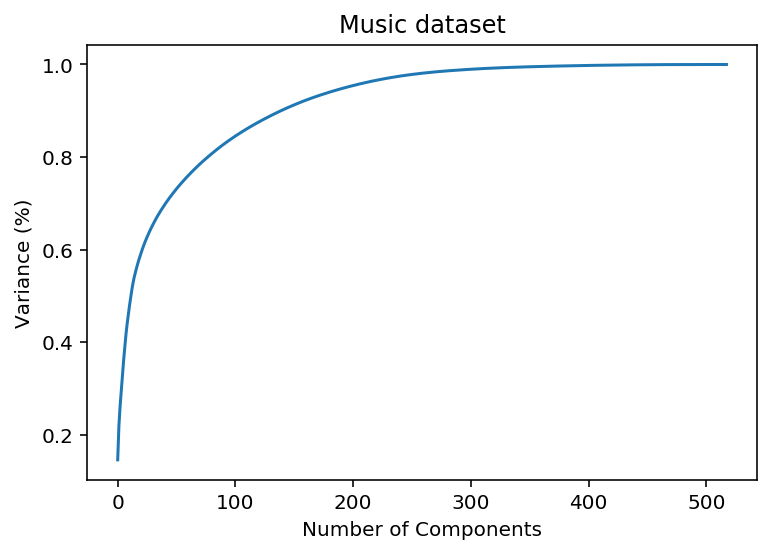

In [ ]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Music dataset')
plt.show()

In [ ]:
pca = PCA(n_components=150)
dataset = pca.fit_transform(data_rescaled)

In [ ]:
import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder

In [ ]:
labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y.astype(str))

In [ ]:
from keras.utils import to_categorical
y_binary = to_categorical(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_binary, test_size=0.2, random_state=1,stratify=y_binary)


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4800, 150) (1200, 150) (4800, 10) (1200, 10)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3840, 150) (1200, 150) (3840, 10) (1200, 10)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation=tf.nn.relu, input_shape=[150]),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(10,activation='softmax')])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [ ]:
model = build_model()

ValueError: ignored

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [ ]:
history=model.fit(X_train,y_train,epochs=40,batch_size=128,validation_data=(X_val,y_val), verbose=1)

Train on 3840 samples, validate on 960 samples
Epoch 1/40
3840/3840 [==============================] - 0s 73us/sample - loss: 1.5405 - acc: 0.4763 - val_loss: 1.0326 - val_acc: 0.6750
Epoch 2/40
3840/3840 [==============================] - 0s 30us/sample - loss: 0.8147 - acc: 0.7461 - val_loss: 0.7289 - val_acc: 0.7740
Epoch 3/40
3840/3840 [==============================] - 0s 29us/sample - loss: 0.5331 - acc: 0.8375 - val_loss: 0.5721 - val_acc: 0.8208
Epoch 4/40
3840/3840 [==============================] - 0s 29us/sample - loss: 0.3678 - acc: 0.8951 - val_loss: 0.5210 - val_acc: 0.8271
Epoch 5/40
3840/3840 [==============================] - 0s 29us/sample - loss: 0.2573 - acc: 0.9354 - val_loss: 0.4784 - val_acc: 0.8448
Epoch 6/40
3840/3840 [==============================] - 0s 29us/sample - loss: 0.1841 - acc: 0.9521 - val_loss: 0.4348 - val_acc: 0.8583
Epoch 7/40
3840/3840 [==============================] - 0s 29us/sample - loss: 0.1218 - acc: 0.9766 - val_loss: 0.4464 - val_acc: 0

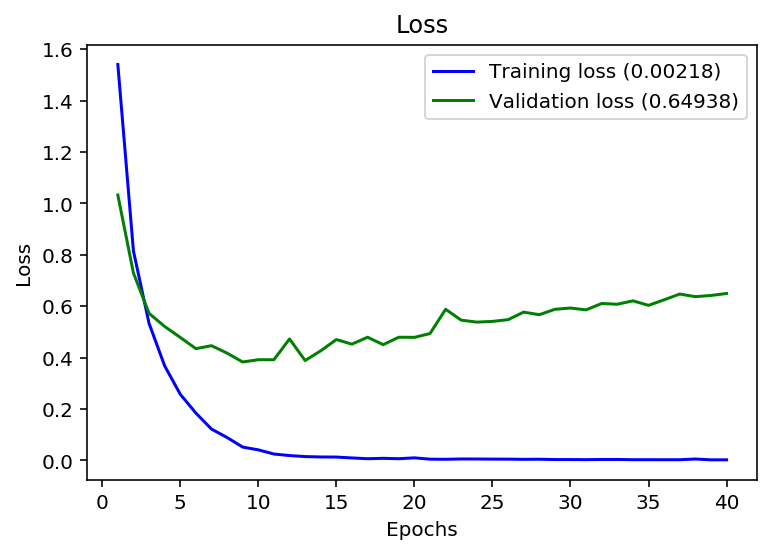

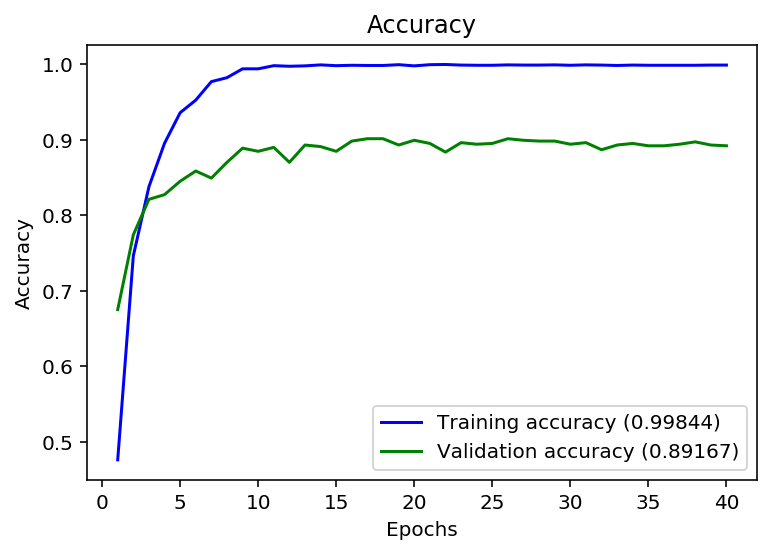

In [ ]:
plot_history(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed = 1000

Accuracy : 0.89

Classification Report
              precision    recall  f1-score   support

           0    0.87097   0.90000   0.88525       120
           1    0.95726   0.93333   0.94515       120
           2    0.84000   0.87500   0.85714       120
           3    0.86726   0.81667   0.84120       120
           4    0.93805   0.88333   0.90987       120
           5    0.89683   0.94167   0.91870       120
           6    0.92800   0.96667   0.94694       120
           7    0.88618   0.90833   0.89712       120
           8    0.89655   0.86667   0.88136       120
           9    0.82203   0.80833   0.81513       120

   micro avg    0.89000   0.89000   0.89000      1200
   macro avg    0.89031   0.89000   0.88978      1200
weighted avg    0.89031   0.89000   0.88978      1200

[[108   0   2   1   0   5   1   0   0   3]
 [  0 112   0   0   0   5   1   0   1   1]
 [  4   0 105   2   0   1   1   3   1   3]
 [  5   0   3  98   1   1   1   3   4   4]
 [  0   0   1   2 106   0   2 

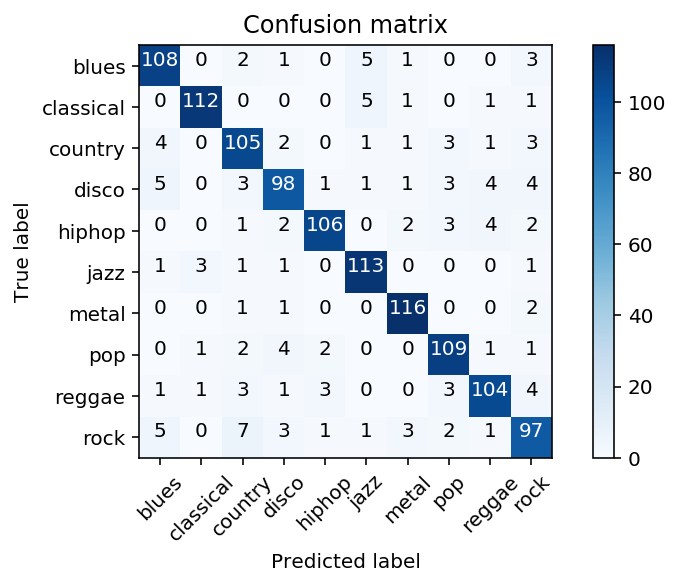

In [ ]:
full_multiclass_report(model,
                       X_test,
                       y_test,
                       labelEncoder.inverse_transform(np.arange(10)))

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
model.predict_classes(X_test)

array([8, 7, 0, ..., 6, 1, 1])